<a href="https://colab.research.google.com/github/marcuse418/synthetic_data_project/blob/main/Synthetic_Data_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Enhancing Predictive Analytics in BI with AI-Generated Synthetic Data**

This Python script will conduct an EDA, develop a baseline model, generate synthetic data, use this to develop an augmented dataset and then evaluate it.

This project aims to demonstrate the value of synthetic data in a data-scarce scenario. This will be simulated by taking a small sample of a larger dataset and then augmenting it with synthetically generated data. The goal is to see if models trained on the augmented data can outperform models trained on only the small, "scarce" dataset, ideally approaching the performance of models trained on the full dataset.

Data Source: [COFINFAD](https://data.mendeley.com/datasets/mhb4zn3258/1)

## **1. Objectives**
**Research Question:** To what degree does AI-generated synthetic data improve the performance and accuracy of customer churn prediction models in data-scarce business environments?

### **1.1 Methodology**

1. **Load & Preprocess Data:** Load the full dataset and prepare it for modeling (handle missing values, encode features).
2. **Engineer Target Variable:** Create the binary 'churn' label.
3. **Split Data:** Separate the data into a main training set (80%) and a final hold-out test set (20%). The test set will be used to evaluate all models.
4. **Establish Baselines:**
    1. **Full Data Baseline:** Train models on the 80% training set and evaluate on the 20% test set.
    2. **Scarce Data Baseline:** Create a "scarce" dataset by sampling 20% of the training data. Train models on this scarce data and evaluate on the same 20% test set.
5. **Generate Synthetic Data:** Use the scarce dataset to train three different synthetic data generators: CTGAN, TVAE, and CopulaGAN.
6. **Augment Data:** Create three augmented datasets by combining the scarce data with the data from each synthesiser.
7. **Train & Evaluate Augmented Models:** Train models on each augmented dataset and evaluate them against the same 20% test set.
8. **Compare Results:** Analyze and compare the performance of all models (Baseline, Scarce, and Augmented) using metrics like Accuracy, Precision, Recall, and F1-Score for the churn class.

### **1.2 Flowchart**

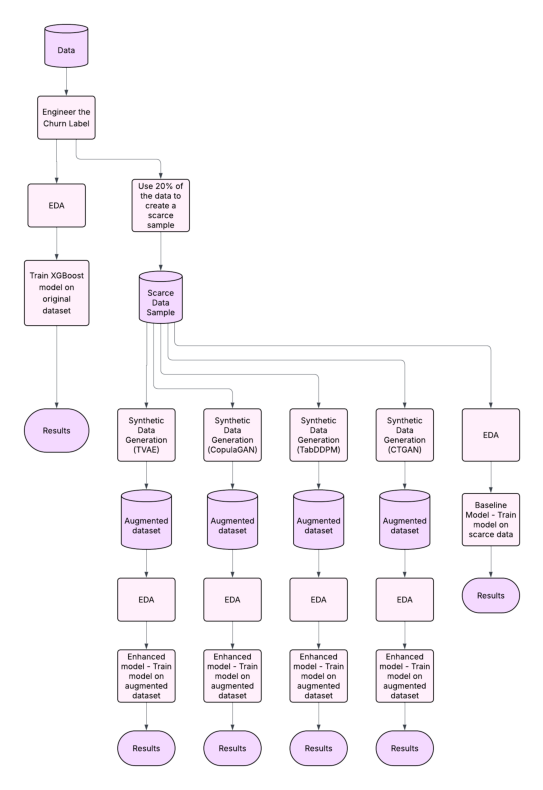

In [1]:
# @title
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('/content/drive/MyDrive/AI_Data_Project/Project Notebooks/SDR/SyntheticDataFlowchart-1.png')
plt.figure(figsize=(15, 10)) # Adjust the figure size as needed (width, height)
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

## **2. Setup**

In [2]:
%pip install sdv imblearn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality
from sdv.evaluation.single_table import get_column_plot
import xgboost as xgb
import random
import torch
import tensorflow as tf

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
tf.random.set_seed(SEED)

sns.set_style("whitegrid")

## **3. Load and View Data**

In [3]:
df_raw = pd.read_csv('/content/drive/MyDrive/AI_Data_Project/Data/Columbian Fintech Financial Analytics/customer_data.csv')
display(df_raw.head())
display(df_raw.info())
display(df_raw.shape)

,customer_id,age,gender,location,income_bracket,occupation,education_level,marital_status,household_size,acquisition_channel,...,total_transaction_volume,transaction_frequency,last_transaction_date,preferred_transaction_type,first_transaction_date,weekend_transaction_ratio,avg_daily_transactions,customer_tenure,churn_probability,customer_lifetime_value
0,93716481,44,Male,"Pereira, Risaralda",Very High,Engineer,Master,Married,5,Partnership,...,60540250,0.030769,2023-12-05,Transfer,2023-01-05,0.300000,0.030769,11.633333,0.362269,3.124148e+08
1,49020929,44,Male,"Cali, Valle del Cauca",Medium,Construction Worker,Bachelor,Married,2,Paid Ad,...,23401550,0.032934,2023-12-18,Transfer,2023-02-05,0.181818,0.032934,11.500000,0.181790,1.670223e+08
2,52690950,45,Male,"Barranquilla, Atlántico",High,Construction Worker,Bachelor,Married,4,Paid Ad,...,35759150,0.050000,2023-10-27,Transfer,2023-01-31,0.300000,0.050000,8.766667,0.321265,1.940371e+07
3,23199751,45,Male,"Bogotá, Cundinamarca",High,Electrician,High School,Single,2,Referral,...,21186950,0.047782,2023-11-30,Transfer,2023-01-10,0.142857,0.047782,10.733333,0.336629,3.597811e+07
4,61997066,44,Female,"Bogotá, Cundinamarca",Medium,Cleaner,Bachelor,Married,3,Paid Ad,...,11640800,0.061889,2023-11-17,Payment,2023-01-05,0.315789,0.061889,11.633333,0.398151,3.046620e+08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48723 entries, 0 to 48722
Data columns (total 54 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customer_id                 48723 non-null  int64  
 1   age                         48723 non-null  int64  
 2   gender                      48723 non-null  object 
 3   location                    48723 non-null  object 
 4   income_bracket              48723 non-null  object 
 5   occupation                  48723 non-null  object 
 6   education_level             48723 non-null  object 
 7   marital_status              48723 non-null  object 
 8   household_size              48723 non-null  int64  
 9   acquisition_channel         48723 non-null  object 
 10  customer_segment            48723 non-null  object 
 11  savings_account             48723 non-null  bool   
 12  credit_card                 48723 non-null  bool   
 13  personal_loan               487

None

(48723, 54)

## **4. Data Preprocessing & Feature Engineering**

In [4]:
# Create a working copy
df = df_raw.copy()

# Handle missing values
# Convert missing values in credit utilisation ratio to 0
df['credit_utilization_ratio'] = df['credit_utilization_ratio'].fillna(0)

# Convert feature requests to "No Requests"
df['feature_requests'] = df['feature_requests'].fillna('No Requests')

# Convert complaint topics to "No Complaints".
df['complaint_topics'] = df['complaint_topics'].fillna('No Complaints')

### **4.1 Churn Label Engineering**
Define the churn label.

Options
1. Choose a freeze date such as the last transaction date, and label as churned if the last transaction is x days before the data freeze date.
2. Churn = 1 if no transactions in the last 60 days or customer_segment = "inactive", else 0.

Whether a customer churned depends on business rules. Two commonly used approaches:

Inactivity window: label as churned if last_transaction_date is more than X days before the data freeze date (the maximum observed date).

Low activity rule: label as churned if recent activity (e.g., avg_daily_transactions or transaction_frequency) falls below a threshold.

Do not use churn_probability as the target. Treat it as a legacy score and exclude from features to avoid leakage.

For digital banking and finance, churn is usually inactivity over time relative to a customers normal activity levels.



In [5]:
# Create the churn label

def label_churn(df, inactivity_days=60, min_tx_per_day=0.05):
  """
  Churn is based on recency and activity rules

  Parameters
  ----------
  df: pd.DataFrame
    Customer dataset with 'last_transaction_date', 'avg_daily_transactions'.
  inactivity_days : int
    Threshold of days since last transaction to consider churn.
  min_tx_per_day : float
    Minimum average daily transactions to be considered an active customer.

  Returns
  -------
  pd.Series
    Binary churn label (1 = churn, 0 = active).
  """

  # Convert to datetime
  df['last_transaction_date'] = pd.to_datetime(df['last_transaction_date'])
  df['first_transaction_date'] = pd.to_datetime(df['first_transaction_date'])

  # Freeze date = the most recent transaction in the dataset
  freeze_date = df['last_transaction_date'].max()

  # Days since last transaction
  df['days_since_last_transaction'] = (freeze_date - df['last_transaction_date']).dt.days

  # Rule 1: Inactivity
  rule_inactivity = df['days_since_last_transaction'] > inactivity_days

  # Rule 2: Low Activity
  rule_low_activity = df['avg_daily_transactions'] < min_tx_per_day

  # Hybrid churn definition
  churn_label = np.where(rule_low_activity | rule_inactivity, 1, 0)

  return pd.Series(churn_label, name='churn_label')

# Apply the churn labeling
df['churn'] = label_churn(df)

# Check
print(df[['customer_id', 'last_transaction_date', 'avg_daily_transactions', 'churn']])

       customer_id last_transaction_date  avg_daily_transactions  churn
0         93716481            2023-12-05                0.030769      1
1         49020929            2023-12-18                0.032934      1
2         52690950            2023-10-27                0.050000      1
3         23199751            2023-11-30                0.047782      1
4         61997066            2023-11-17                0.061889      0
...            ...                   ...                     ...    ...
48718     58327025            2023-11-10                0.068404      0
48719     32505842            2023-12-19                0.160350      0
48720     97779703            2023-12-26                0.045732      1
48721     11796475            2023-12-15                0.037037      1
48722     41811965            2023-12-28                0.042373      1

[48723 rows x 4 columns]


### **4.2 Data Preprocessing**

In [6]:
# Define features (X) and target (y)
# Drop non-predictive or leaky columns

features_to_drop = ['customer_id',
                    'churn_probability',
                    'customer_lifetime_value',
                    'first_tx',
                    'last_tx',
                    'last_survey_date',
                    'first_transaction_date',
                    'last_transaction_date',
                    'days_since_last_transaction',
                    'avg_daily_transactions',
                    'clv_segment',
                    ]

# Identify categorical columns for encoding
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()

# Ensure 'churn' is not in the list of features to be encoded
if 'churn' in categorical_cols:
    categorical_cols.remove('churn')

print(f"Categorical features to encode: {categorical_cols}")

Categorical features to encode: ['gender', 'location', 'income_bracket', 'occupation', 'education_level', 'marital_status', 'acquisition_channel', 'customer_segment', 'savings_account', 'credit_card', 'personal_loan', 'investment_account', 'insurance_product', 'bill_payment_user', 'auto_savings_enabled', 'first_tx', 'last_tx', 'last_survey_date', 'feedback_sentiment', 'feature_requests', 'complaint_topics', 'clv_segment', 'preferred_transaction_type']


In [7]:
# Create a working copy for splitting
df_for_split = df.copy()

# Define features (X) and target (y) with raw categorical values
# Drop non-predictive or leaky columns and the target
X_raw = df_for_split.drop(columns=features_to_drop + ['churn'])
y_raw = df_for_split['churn']

# The unified_label_encoders dictionary will be populated after the train-test split
unified_label_encoders = {}

print("X_raw and y_raw defined with raw categorical values. Categorical columns will be encoded after train-test split.")

X_raw and y_raw defined with raw categorical values. Categorical columns will be encoded after train-test split.


## **6. EDA on Full Dataset**

(48723, 56)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48723 entries, 0 to 48722
Data columns (total 56 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   customer_id                  48723 non-null  int64         
 1   age                          48723 non-null  int64         
 2   gender                       48723 non-null  object        
 3   location                     48723 non-null  object        
 4   income_bracket               48723 non-null  object        
 5   occupation                   48723 non-null  object        
 6   education_level              48723 non-null  object        
 7   marital_status               48723 non-null  object        
 8   household_size               48723 non-null  int64         
 9   acquisition_channel          48723 non-null  object        
 10  customer_segment             48723 non-null  object        
 11  savings_account              

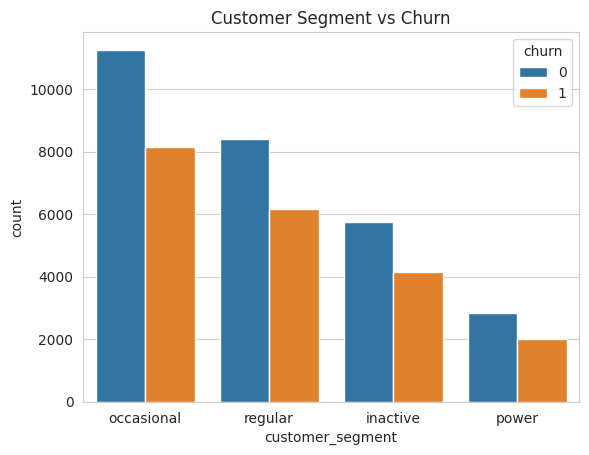

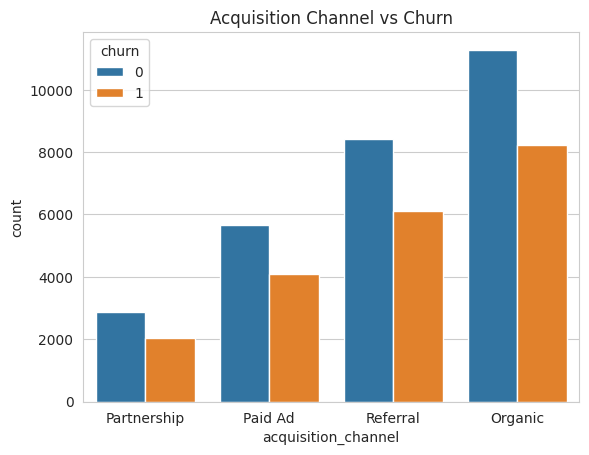

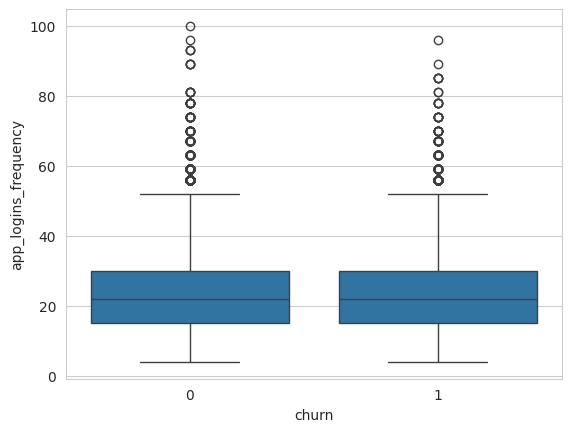

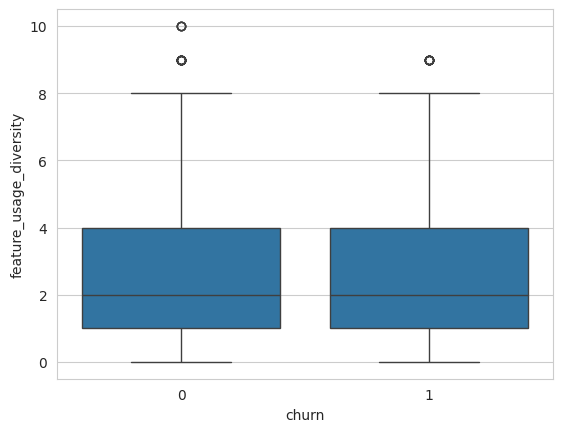

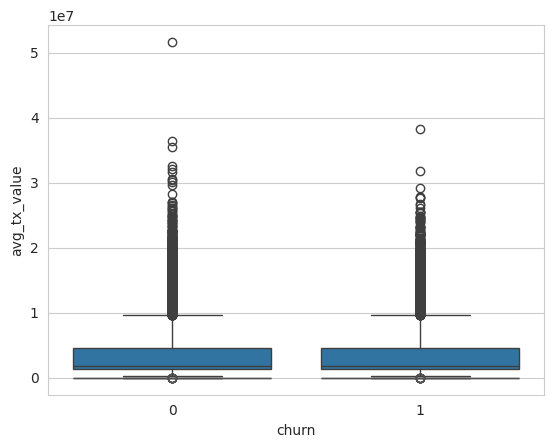

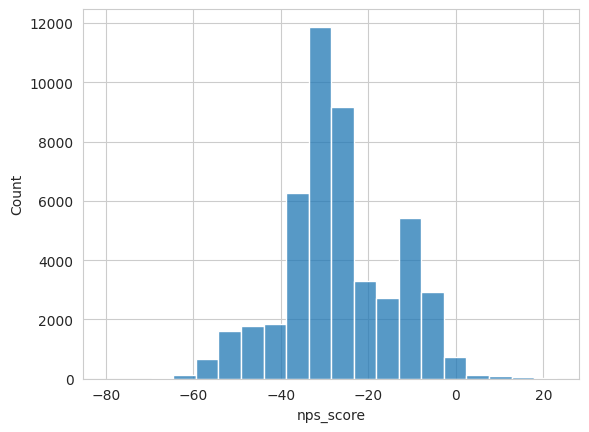

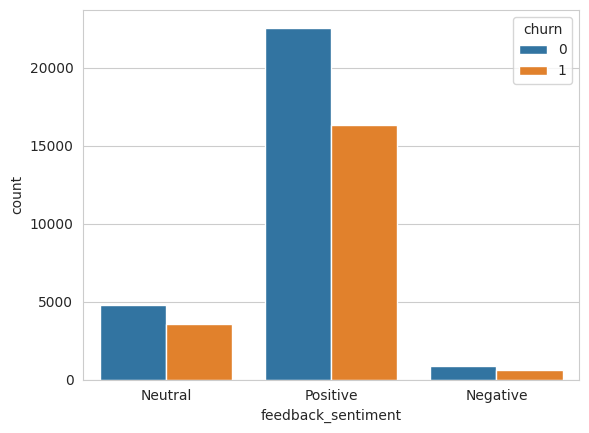

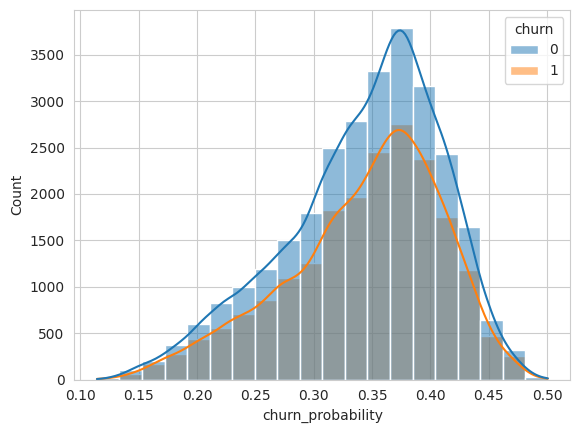

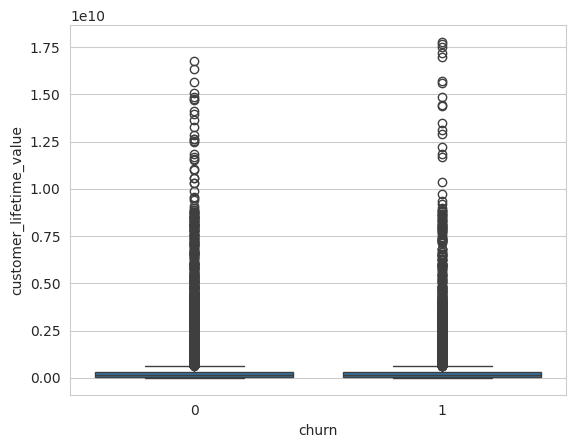

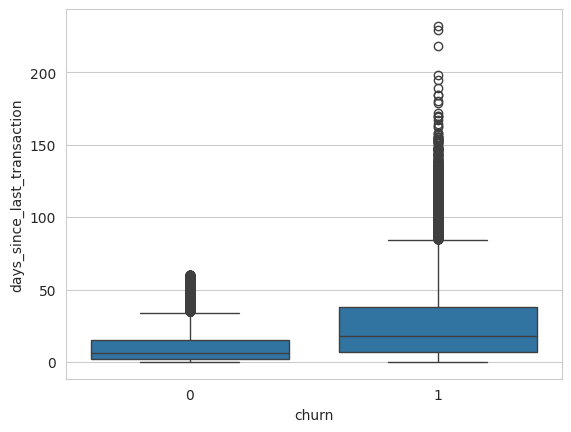

Text(0.5, 1.0, 'Correlation Heatmap')

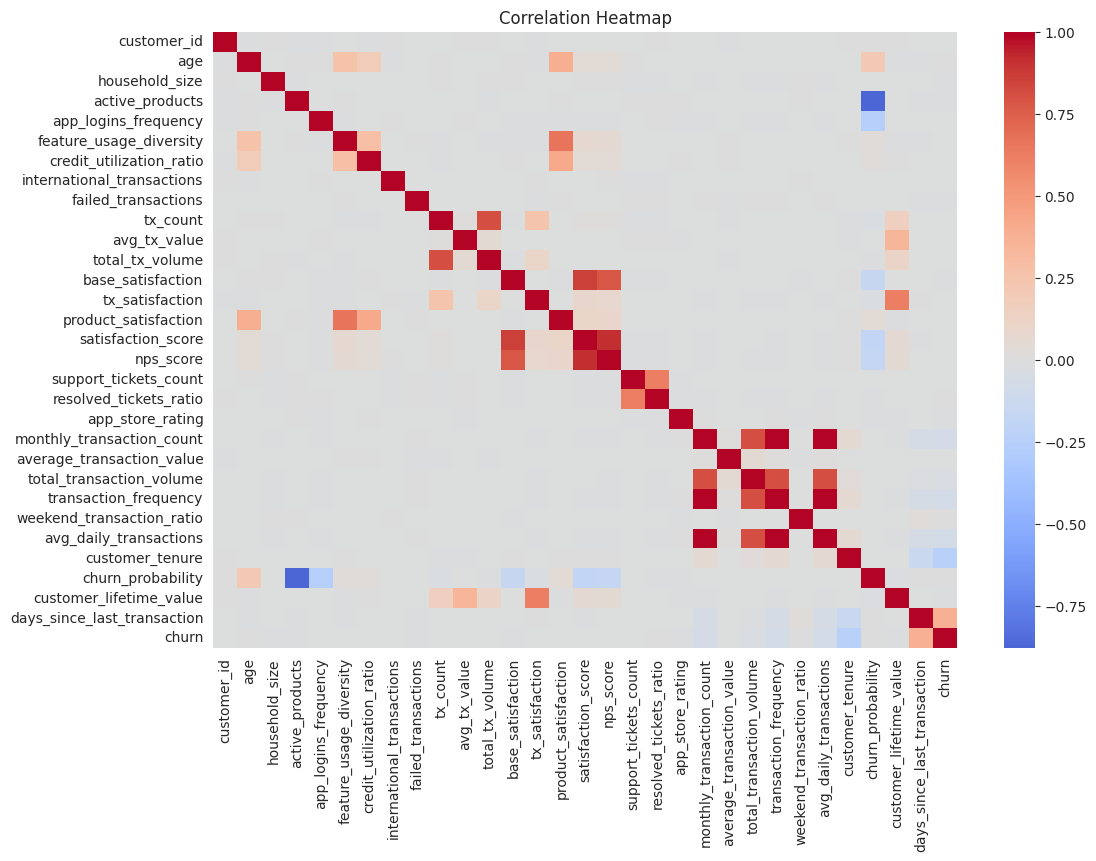

In [8]:
# EDA

# Data Overview
print(df.shape)
print(df.info())
print(df.head())

# Customer segmentation
sns.countplot(x="customer_segment", hue="churn", data=df)
plt.title("Customer Segment vs Churn")
plt.show()

sns.countplot(x="acquisition_channel", hue="churn", data=df)
plt.title("Acquisition Channel vs Churn")
plt.show()

# Product and feature usage

# Logins vs churn
sns.boxplot(x="churn", y="app_logins_frequency", data=df)
plt.show()

# Feature diversity
sns.boxplot(x="churn", y="feature_usage_diversity", data=df)
plt.show()
# Transaction Behaviour

# Avg transaction value by churn
sns.boxplot(x="churn", y="avg_tx_value", data=df)
# Customer Satisfaction

# Satisfaction scores
sns.boxplot(x="churn", y="satisfaction_score", data=df)
plt.show()

# NPS distribution
sns.histplot(df['nps_score'], bins=20)
plt.show()

# Sentiment breakdown
sns.countplot(x="feedback_sentiment", hue="churn", data=df)
plt.show()

# Churn probability vs actual churn
sns.histplot(data=df, x='churn_probability', hue='churn', bins=20, kde=True)
plt.show()

# CLV distribution
sns.boxplot(x="churn", y="customer_lifetime_value", data=df)
plt.show()

# Days since last transaction
sns.boxplot(x="churn", y="days_since_last_transaction", data=df)
plt.show()

# Numeric correlation matrix
corr = df.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")


## **7. Model Training and Evaluation**
Train Logistic Regression and XGBoost models. Results will be stored in a DataFrame for camparison.

### 7.1 Data Splitting

In [9]:
# Split the raw dataset into training (80%) and test (20%) sets
# This test set will be our final, unseen data to evaluate all models
X_train_full_raw, X_test_raw, y_train_full, y_test = train_test_split(
    X_raw, y_raw, # X_raw and y_raw here still contain object dtypes for categorical columns
    test_size=0.2,
    random_state=42,
    stratify=y_raw # Stratify by the raw target
)

# Initialize LabelEncoders and fit ONLY on the training data (X_train_full_raw)
X_train_full_encoded = X_train_full_raw.copy() # Will hold the encoded training features
X_test_encoded = X_test_raw.copy() # Will hold the encoded test features

for col in categorical_cols:
    if col in X_train_full_encoded.columns: # Ensure column exists before processing
        le = LabelEncoder()
        # Fit on training data only
        le.fit(X_train_full_encoded[col].astype(str))
        unified_label_encoders[col] = le

        # Transform training data
        X_train_full_encoded[col] = le.transform(X_train_full_encoded[col].astype(str))

        # Transform test data using the *fitted* encoder
        test_col_transformed = []
        for item in X_test_encoded[col].astype(str):
            if item in le.classes_:
                test_col_transformed.append(le.transform([item])[0])
            else:
                test_col_transformed.append(-1) # Assign -1 for unseen categories
        X_test_encoded[col] = pd.Series(test_col_transformed, index=X_test_encoded.index, dtype=int)

# Rename for clarity for subsequent steps
X_train_full = X_train_full_encoded
X_test = X_test_encoded


# Simulate data scarcity: Create a "scarce" dataset from the original (raw string) training data.
# This `df_scarce_train` will be used for SDV synthesizers and metadata generation,
# as they generally expect original data types.
scarce_indices, _ = train_test_split(
    X_train_full_raw.index, # Use indices from the original raw training data
    test_size=0.99,  # Get 5% of the original raw training data
    random_state=42,
    stratify=y_train_full # Stratify based on the target of the full training set
)
df_scarce_train = df.loc[scarce_indices].copy() # This keeps original string categories for SDV

# Create the scarce training data (X, y) for model training, which must be encoded.
# This means taking the scarce subset of the *already encoded* X_train_full.
X_train_scarce = X_train_full.loc[scarce_indices].copy()
y_train_scarce = y_train_full.loc[scarce_indices].copy()


print(f"Full training set shape: {X_train_full.shape}")
print(f"Scarce training set shape: {X_train_scarce.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"\nTarget distribution in full training set:\n{y_train_full.value_counts(normalize=True)}")
print(f"\nTarget distribution in scarce training set:\n{y_train_scarce.value_counts(normalize=True)}")
print(f"\nTarget distribution in test set:\n{y_test.value_counts(normalize=True)}")

Full training set shape: (38978, 44)
Scarce training set shape: (389, 44)
Test set shape: (9745, 44)

Target distribution in full training set:
churn
0    0.579712
1    0.420288
Name: proportion, dtype: float64

Target distribution in scarce training set:
churn
0    0.580977
1    0.419023
Name: proportion, dtype: float64

Target distribution in test set:
churn
0    0.579682
1    0.420318
Name: proportion, dtype: float64


In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Helper function to train, evaluate, and store results
results = []

def train_evaluate_store(model_name, dataset_name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    precision_0 = precision_score(y_test, y_pred, pos_label=0, zero_division=0)
    recall_0 = recall_score(y_test, y_pred, pos_label=0, zero_division=0)
    f1_0 = f1_score(y_test, y_pred, pos_label=0, zero_division=0)
    precision_1 = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    recall_1 = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    f1_1 = f1_score(y_test, y_pred, pos_label=1, zero_division=0)
    macro_precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    macro_recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    macro_f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    weighted_precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    weighted_recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    weighted_f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    print(f"--- {model_name} Model Performance ({dataset_name} Dataset) ---")
    print(classification_report(y_test, y_pred, zero_division=0))
    print(f"AUC Score: {auc}\n")

    results.append({
        'Model': model_name,
        'Dataset': dataset_name,
        'Accuracy': accuracy,
        'Precision (0)': precision_0,
        'Recall (0)': recall_0,
        'F1-Score (0)': f1_0,
        'Precision (1)': precision_1,
        'Recall (1)': recall_1,
        'F1-Score (1)': f1_1,
        'Macro Avg Precision': macro_precision,
        'Macro Avg Recall': macro_recall,
        'Macro Avg F1': macro_f1,
        'Weighted Avg Precision': weighted_precision,
        'Weighted Avg Recall': weighted_recall,
        'Weighted Avg F1': weighted_f1,
        'AUC': auc
    })

### **7.2 Baseline Models (Full Data)**

These models are trained on the full 80% training set.

In [11]:
results = []

# Logistic Regression (Baseline)
model_lr_full = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced', max_iter=1000)
train_evaluate_store('Logistic Regression', 'Full', model_lr_full, X_train_full, y_train_full, X_test, y_test)

# XGBoost (Baseline)
scale_pos_weight_full = sum(y_train_full == 0) / sum(y_train_full == 1)
model_xgb_full = xgb.XGBClassifier(eval_metric='logloss', random_state=42, scale_pos_weight=scale_pos_weight_full)
train_evaluate_store('XGBoost', 'Full', model_xgb_full, X_train_full, y_train_full, X_test, y_test)

--- Logistic Regression Model Performance (Full Dataset) ---
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      5649
           1       0.91      0.97      0.94      4096

    accuracy                           0.95      9745
   macro avg       0.94      0.95      0.95      9745
weighted avg       0.95      0.95      0.95      9745

AUC Score: 0.9809305816018321

--- XGBoost Model Performance (Full Dataset) ---
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5649
           1       1.00      0.98      0.99      4096

    accuracy                           0.99      9745
   macro avg       0.99      0.99      0.99      9745
weighted avg       0.99      0.99      0.99      9745

AUC Score: 0.9991008416174324



### **7.3 Scarce Data Models**

Models trained on the 20% sample of the training data.

In [12]:
# Logistic Regression (Scarce)
model_lr_scarce = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced', max_iter=1000)
train_evaluate_store('Logistic Regression', 'Scarce', model_lr_scarce, X_train_scarce, y_train_scarce, X_test, y_test)

# XGBoost (Scarce)
scale_pos_weight_scarce = sum(y_train_scarce == 0) / sum(y_train_scarce == 1)
model_xgb_scarce = xgb.XGBClassifier(eval_metric='logloss', random_state=42, scale_pos_weight=scale_pos_weight_scarce)
train_evaluate_store('XGBoost', 'Scarce', model_xgb_scarce, X_train_scarce, y_train_scarce, X_test, y_test)

--- Logistic Regression Model Performance (Scarce Dataset) ---
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      5649
           1       0.88      0.98      0.93      4096

    accuracy                           0.93      9745
   macro avg       0.93      0.94      0.93      9745
weighted avg       0.94      0.93      0.94      9745

AUC Score: 0.9752961582663966

--- XGBoost Model Performance (Scarce Dataset) ---
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      5649
           1       0.97      0.96      0.96      4096

    accuracy                           0.97      9745
   macro avg       0.97      0.97      0.97      9745
weighted avg       0.97      0.97      0.97      9745

AUC Score: 0.9868196044100724



### **7.4 Scarce Data Models with SMOTE**

Models trained on the 20% sample of the training data, augmented with SMOTE.

In [13]:
# The installation of imblearn has been moved to the main setup cell.

from imblearn.over_sampling import SMOTE

# Apply SMOTE to the scarce training data
smote = SMOTE(random_state=SEED)
X_train_scarce_smote, y_train_scarce_smote = smote.fit_resample(X_train_scarce, y_train_scarce)

print(f"Original scarce training set shape: {X_train_scarce.shape}")
print(f"SMOTE-augmented scarce training set shape: {X_train_scarce_smote.shape}")
print(f"\nTarget distribution in SMOTE-augmented scarce training set:\n{y_train_scarce_smote.value_counts(normalize=True)}")

Original scarce training set shape: (389, 44)
SMOTE-augmented scarce training set shape: (452, 44)

Target distribution in SMOTE-augmented scarce training set:
churn
0    0.5
1    0.5
Name: proportion, dtype: float64


In [14]:
# Logistic Regression (Scarce + SMOTE)
model_lr_scarce_smote = LogisticRegression(random_state=SEED, solver='liblinear', class_weight='balanced', max_iter=1000)
train_evaluate_store('Logistic Regression', 'Scarce + SMOTE', model_lr_scarce_smote, X_train_scarce_smote, y_train_scarce_smote, X_test, y_test)

# XGBoost (Scarce + SMOTE)
# For SMOTE-augmented data, classes are balanced, so scale_pos_weight can be 1 or omitted.
scale_pos_weight_scarce_smote = sum(y_train_scarce_smote == 0) / sum(y_train_scarce_smote == 1)
model_xgb_scarce_smote = xgb.XGBClassifier(eval_metric='logloss', random_state=SEED, scale_pos_weight=scale_pos_weight_scarce_smote)
train_evaluate_store('XGBoost', 'Scarce + SMOTE', model_xgb_scarce_smote, X_train_scarce_smote, y_train_scarce_smote, X_test, y_test)

--- Logistic Regression Model Performance (Scarce + SMOTE Dataset) ---
              precision    recall  f1-score   support

           0       0.98      0.91      0.94      5649
           1       0.89      0.98      0.93      4096

    accuracy                           0.94      9745
   macro avg       0.93      0.94      0.94      9745
weighted avg       0.94      0.94      0.94      9745

AUC Score: 0.9759846702679676

--- XGBoost Model Performance (Scarce + SMOTE Dataset) ---
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      5649
           1       0.97      0.96      0.96      4096

    accuracy                           0.97      9745
   macro avg       0.97      0.97      0.97      9745
weighted avg       0.97      0.97      0.97      9745

AUC Score: 0.9872306760253474



### **7.5 TabDDPM Class Definition**

A simplified TabDDPM implemented using PyTorch.

In [15]:
# Setup
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

In [16]:
class SimpleTabDDPM:
    """
    A simple TabDDPM implementation using PyTorch.
    """
    def __init__(self, n_steps=200, min_beta=1e-4, max_beta=0.02, device=None):
        self.n_steps = n_steps
        self.min_beta = min_beta
        self.max_beta = max_beta
        self.device = device if device else ('cuda' if torch.cuda.is_available() else 'cpu')

        # Define betas and alphas
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(self.device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

        self.model = None
        self.scaler = StandardScaler()
        self.input_dim = None

    def _build_model(self):
        # A simple MLP denoiser
        return nn.Sequential(
            nn.Linear(self.input_dim + 1, 256), # +1 for time embedding
            nn.SiLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.SiLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.SiLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, self.input_dim)
        ).to(self.device)

    def fit(self, df, epochs=500, batch_size=64, lr=1e-3, verbose=True):
        # Preprocess data
        data = self.scaler.fit_transform(df.values)
        self.input_dim = data.shape[1]
        self.model = self._build_model()

        dataset = TensorDataset(torch.tensor(data, dtype=torch.float32))
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        optimizer = optim.Adam(self.model.parameters(), lr=lr)
        criterion = nn.MSELoss()

        self.model.train()
        for epoch in range(epochs):
            total_loss = 0
            for batch_x, in loader:
                batch_x = batch_x.to(self.device)
                t = torch.randint(0, self.n_steps, (batch_x.shape[0],), device=self.device).long()
                epsilon = torch.randn_like(batch_x)

                # Forward diffusion
                alpha_bar_t = self.alpha_bars[t].unsqueeze(1)
                noisy_x = torch.sqrt(alpha_bar_t) * batch_x + torch.sqrt(1 - alpha_bar_t) * epsilon

                # Time embedding (simple concatenation)
                t_input = t.view(-1, 1).float() / self.n_steps
                model_input = torch.cat([noisy_x, t_input], dim=1)

                # Predict noise
                pred_epsilon = self.model(model_input)
                loss = criterion(pred_epsilon, epsilon)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            if verbose and (epoch + 1) % 50 == 0:
                print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss / len(loader):.5f}")

    def sample(self, num_rows):
        self.model.eval()
        with torch.no_grad():
            # Start from pure noise
            x = torch.randn(num_rows, self.input_dim).to(self.device)

            for t in reversed(range(self.n_steps)):
                z = torch.randn_like(x) if t > 0 else 0
                t_tensor = (torch.ones(num_rows, 1) * t / self.n_steps).to(self.device)

                # Predict noise
                model_input = torch.cat([x, t_tensor], dim=1)
                pred_epsilon = self.model(model_input)

                # Denoise step
                alpha_t = self.alphas[t]
                alpha_bar_t = self.alpha_bars[t]
                beta_t = self.betas[t]

                sigma_t = torch.sqrt(beta_t)
                x = (1 / torch.sqrt(alpha_t)) * (x - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * pred_epsilon) + sigma_t * z

        # Inverse transform to original scale
        x_np = x.cpu().numpy()
        return pd.DataFrame(self.scaler.inverse_transform(x_np), columns=self.scaler.get_feature_names_out())

print("SimpleTabDDPM class defined.")

SimpleTabDDPM class defined.


## **8. Synthetic Data Generation & Evaluation**

Generate synthetic data based on the scarce dataset (df_scarce_train).

In [17]:
# Create metadata

from sdv.metadata import Metadata

#metadata = Metadata.detect_from_dataframe(df_scarce_train)

# Save metadata

# metadata.save_to_json('/content/drive/MyDrive/AI_Data_Project/Project Notebooks/SDR/metadata-1.json')

Auto detected data:



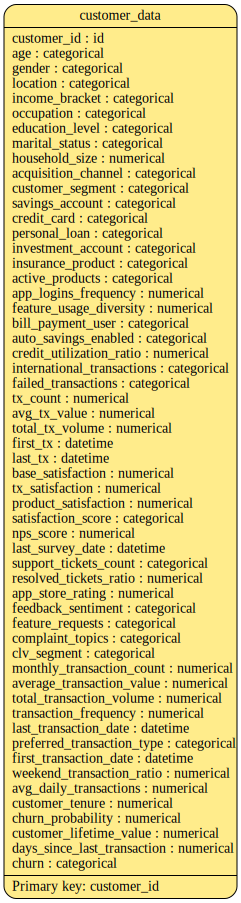

In [18]:
# Load metadata

metadata = Metadata.load_from_json('/content/drive/MyDrive/AI_Data_Project/Project Notebooks/SDR/metadata-1.json')

# View metadata

print('Auto detected data:\n')
metadata.visualize()

In [19]:
# Calculate the number of rows to generate (match the original full training set size)

num_synthetic_rows = len(X_train_full) - len(X_train_scarce)
print(f"Generating {num_synthetic_rows} synthetic samples...")

Generating 38589 synthetic samples...


### **8.1 CTGAN**

In [20]:
# Create synthesizer

from sdv.single_table import CTGANSynthesizer

synthesizer = CTGANSynthesizer(metadata, epochs=800, verbose=True)
synthesizer.fit(df_scarce_train)
# Save synthesiser
synthesizer.save('/content/drive/MyDrive/AI_Data_Project/Project Notebooks/SDR/ctgan_synthesizer-2.pkl')

/usr/local/lib/python3.12/dist-packages/ctgan/synthesizers/_utils.py:16: FutureWarning: `cuda` parameter is deprecated and will be removed in a future release. Please use `enable_gpu` instead.
  warnings.warn(
Gen. (-3.47) | Discrim. (0.20): 100%|██████████| 800/800 [00:59<00:00, 13.52it/s]


In [21]:
# Load CTGAN Synthesiser

from sdv.utils import load_synthesizer

ctgan_synthesizer = load_synthesizer('/content/drive/MyDrive/AI_Data_Project/Project Notebooks/SDR/ctgan_synthesizer-2.pkl')

# Generate synthetic data
ctgan_synthetic_data = ctgan_synthesizer.sample(num_rows=num_synthetic_rows)
print("CTGAN synthetic data generated.")

# Create augmented dataset
ctgan_augmented_data = pd.concat([df_scarce_train, ctgan_synthetic_data], ignore_index=True)
print(f"CTGAN augmented dataset shape: {ctgan_augmented_data.shape}")

# Evaluate data quality
ctgan_quality_report = evaluate_quality(
    real_data=df_scarce_train,
    synthetic_data=ctgan_synthetic_data,
    metadata=metadata
)
print(f"CTGAN Data Quality Score: {ctgan_quality_report.get_score():.2%}")

from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data=df_scarce_train,
    synthetic_data=ctgan_synthetic_data,
    metadata=metadata,
    column_name='churn'
)

fig.show()

CTGAN synthetic data generated.
CTGAN augmented dataset shape: (38978, 56)
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 56/56 [00:00<00:00, 213.81it/s]|
Column Shapes Score: 80.27%

(2/2) Evaluating Column Pair Trends: |██████████| 1540/1540 [00:14<00:00, 103.11it/s]|
Column Pair Trends Score: 81.66%

Overall Score (Average): 80.97%

CTGAN Data Quality Score: 80.97%


### **8.2 TVAE**

In [22]:
# Create synthesizer

from sdv.single_table import TVAESynthesizer

tvae_synthesizer = TVAESynthesizer(metadata, epochs=800, verbose=True)
tvae_synthesizer.fit(df_scarce_train)

# Save synthesiser
tvae_synthesizer.save('/content/drive/MyDrive/AI_Data_Project/Project Notebooks/SDR/tvae_synthesizer-2.pkl')

/usr/local/lib/python3.12/dist-packages/ctgan/synthesizers/_utils.py:16: FutureWarning:

`cuda` parameter is deprecated and will be removed in a future release. Please use `enable_gpu` instead.

Loss: -15.042: 100%|██████████| 800/800 [00:28<00:00, 27.60it/s]


In [23]:
# Load TVAE Synthesiser

tvae_synthesizer = load_synthesizer('/content/drive/MyDrive/AI_Data_Project/Project Notebooks/SDR/tvae_synthesizer-2.pkl')

# Generate synthetic data
tvae_synthetic_data = tvae_synthesizer.sample(num_rows=num_synthetic_rows)
print("TVAE synthetic data generated.")

# Create augmented dataset
tvae_augmented_data = pd.concat([df_scarce_train, tvae_synthetic_data], ignore_index=True)
print(f"TVAE augmented dataset shape: {tvae_augmented_data.shape}")

# Evaluate data quality
tvae_quality_report = evaluate_quality(
    real_data=df_scarce_train,
    synthetic_data=tvae_synthetic_data,
    metadata=metadata
)
print(f"TVAE Data Quality Score: {tvae_quality_report.get_score():.2%}")

fig = get_column_plot(
    real_data=df_scarce_train,
    synthetic_data=tvae_synthetic_data,
    metadata=metadata,
    column_name='churn'
)

fig.show()

TVAE synthetic data generated.
TVAE augmented dataset shape: (38978, 56)
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 56/56 [00:00<00:00, 211.69it/s]|
Column Shapes Score: 88.98%

(2/2) Evaluating Column Pair Trends: |██████████| 1540/1540 [00:16<00:00, 93.92it/s]|
Column Pair Trends Score: 85.35%

Overall Score (Average): 87.16%

TVAE Data Quality Score: 87.16%


### **8.3 CopulaGAN**

In [24]:
from sdv.single_table import CopulaGANSynthesizer

copulagan_synthesizer = CopulaGANSynthesizer(metadata, verbose=True, epochs=800)
copulagan_synthesizer.fit(df_scarce_train)

# Save synthesiser
copulagan_synthesizer.save('/content/drive/MyDrive/AI_Data_Project/Project Notebooks/SDR/CopulaGAN_synthesizer-2.pkl')

/usr/local/lib/python3.12/dist-packages/ctgan/synthesizers/_utils.py:16: FutureWarning:

`cuda` parameter is deprecated and will be removed in a future release. Please use `enable_gpu` instead.

Gen. (-4.85) | Discrim. (0.21): 100%|██████████| 800/800 [00:56<00:00, 14.24it/s]


In [25]:
# Load CopulaGAN Synthesiser

copulagan_synthesizer = load_synthesizer('/content/drive/MyDrive/AI_Data_Project/Project Notebooks/SDR/CopulaGAN_synthesizer-2.pkl')

# Generate synthetic data
copulagan_synthetic_data = copulagan_synthesizer.sample(num_rows=num_synthetic_rows)
print("CopulaGAN synthetic data generated.")

# Create augmented dataset
copulagan_augmented_data = pd.concat([df_scarce_train, copulagan_synthetic_data], ignore_index=True)
print(f"CopulaGAN augmented dataset shape: {copulagan_augmented_data.shape}")

# Evaluate data quality
copulagan_quality_report = evaluate_quality(
    real_data=df_scarce_train,
    synthetic_data=copulagan_synthetic_data,
    metadata=metadata
)
print(f"CopulaGAN Data Quality Score: {copulagan_quality_report.get_score():.2%}")

fig = get_column_plot(
    real_data=df_scarce_train,
    synthetic_data=copulagan_synthetic_data,
    metadata=metadata,
    column_name='churn'
)

fig.show()

CopulaGAN synthetic data generated.
CopulaGAN augmented dataset shape: (38978, 56)
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 56/56 [00:00<00:00, 226.85it/s]|
Column Shapes Score: 81.95%

(2/2) Evaluating Column Pair Trends: |██████████| 1540/1540 [00:15<00:00, 100.32it/s]|
Column Pair Trends Score: 81.21%

Overall Score (Average): 81.58%

CopulaGAN Data Quality Score: 81.58%


### **8.4 TabDDPM (Diffusion Model)**

In [ ]:
# Initialise TabDDPM
# Note: Increasing n_steps and epochs improves quality but takes longer
ddpm_synthesizer = SimpleTabDDPM(n_steps=400, device='cuda' if torch.cuda.is_available() else 'cpu')

# Prepare the scarce training data for DDPM by ensuring all columns are numerical and encoded.
# X_train_scarce and y_train_scarce are already encoded from the `BuDcynAhDgw5` cell.
df_scarce_train_for_ddpm = pd.concat([X_train_scarce, y_train_scarce], axis=1)

# Train on scarce data
print ("Training TabDDPM...")
ddpm_synthesizer.fit(df_scarce_train_for_ddpm, epochs=800, verbose=True)

Training TabDDPM...
Epoch 50/800 | Loss: 0.50024
Epoch 100/800 | Loss: 0.44465
Epoch 150/800 | Loss: 0.43141
Epoch 200/800 | Loss: 0.40824


In [ ]:
# Generate synthetic data
print(f"Generating {num_synthetic_rows} synthetic samples using TabDDPM...")
ddpm_synthetic_data = ddpm_synthesizer.sample(num_rows=num_synthetic_rows)

# Rename columns of ddpm_synthetic_data to match df_scarce_train_for_ddpm
ddpm_synthetic_data.columns = df_scarce_train_for_ddpm.columns

# Post-processing:
# Since diffusion generates continuous floats, we must round categorical columns
# back to integers to match the LabelEncoded format of the original data.
# Iterate only over the columns that were actually synthesized by DDPM.
for col in ddpm_synthetic_data.columns:
    # Check the original dtype from the data used for training the DDPM
    # df_scarce_train_for_ddpm contains the correctly encoded columns.
    if df_scarce_train_for_ddpm[col].dtype == 'int64' or df_scarce_train_for_ddpm[col].dtype == 'int32':
        ddpm_synthetic_data[col] = ddpm_synthetic_data[col].round().astype(int)

        # Clamp values to min/max of original data to avoid out-of-range encodings
        min_val = df_scarce_train_for_ddpm[col].min()
        max_val = df_scarce_train_for_ddpm[col].max()
        ddpm_synthetic_data[col] = ddpm_synthetic_data[col].clip(min_val, max_val)

print("TabDDPM synthetic data generated.")

In [ ]:
# Create augmented dataset
ddpm_augmented_data = pd.concat([df_scarce_train, ddpm_synthetic_data], ignore_index=True)
print(f"TabDDPM augmented dataset shape: {ddpm_augmented_data.shape}")

# Create metadata specific to the data used for DDPM training and synthesis
# Use df_scarce_train_for_ddpm (the encoded scarce data) for metadata detection.
metadata_ddpm = Metadata.detect_from_dataframe(df_scarce_train_for_ddpm)

# Evaluate data quality
ddpm_quality_report = evaluate_quality(
    real_data=df_scarce_train_for_ddpm, # Compare against the real data used for training DDPM
    synthetic_data=ddpm_synthetic_data,
    metadata=metadata_ddpm
)
print(f"TabDDPM Data Quality Score: {ddpm_quality_report.get_score():.2%}")

# Visual check
fig = get_column_plot(
    real_data=df_scarce_train_for_ddpm,
    synthetic_data=ddpm_synthetic_data,
    metadata=metadata_ddpm,
    column_name='churn' # or 'churn', etc.
)
fig.show()

## **9. Train Models on Augmented Data**

Train the same models on the new augmented datasets and evaluate them against the same test set (X_test, y_test).

### **9.1 Preprocess Augmented Data**

In [ ]:
def preprocess_augmented(df_aug, encoders, categorical_cols_list):
    """
    Preprocesses augmented dataframes by applying label encoding
    and handling potential data type inconsistencies.

    Parameters
    ----------
    df_aug : pd.DataFrame
        The augmented dataframe to preprocess.
    encoders : dict
        A dictionary of pre-fitted LabelEncoders for categorical columns.
    categorical_cols_list : list
        A list of column names that should be treated as categorical.

    Returns
    -------
    tuple
        A tuple containing the preprocessed features (X) and target (y) DataFrames.
    """
    df_aug_copy = df_aug.copy()
    X_aug_temp = df_aug_copy.drop(columns=features_to_drop + ['churn'], errors='ignore')
    y_aug_temp = df_aug_copy['churn']

    for col in categorical_cols_list:
        if col in X_aug_temp.columns:
            # If the column is still of object (string) type, it needs to be encoded.
            if pd.api.types.is_object_dtype(X_aug_temp[col]):
                le = encoders[col]
                # Ensure values are strings for transformation
                current_col_values = X_aug_temp[col].astype(str)

                # Create a mapping for existing classes
                mapping = {cls: i for i, cls in enumerate(le.classes_)}
                # Map known values, and assign -1 for unknown ones (a common practice for unseen categories)
                X_aug_temp[col] = current_col_values.map(mapping).fillna(-1).astype(int)
            # If the column is already numeric and was originally categorical,
            # we just ensure it's an integer type.
            elif pd.api.types.is_numeric_dtype(X_aug_temp[col]):
                X_aug_temp[col] = X_aug_temp[col].round().astype(int)

    # No filtering based on unknown categories, keep all rows
    return X_aug_temp, y_aug_temp

In [ ]:
# Process CTGAN data
X_train_ctgan, y_train_ctgan = preprocess_augmented(ctgan_augmented_data, unified_label_encoders, categorical_cols)

In [ ]:
# Process TVAE data
X_train_tvae, y_train_tvae = preprocess_augmented(tvae_augmented_data, unified_label_encoders, categorical_cols)

In [ ]:
# Process CopulaGAN data
X_train_copulagan, y_train_copulagan = preprocess_augmented(copulagan_augmented_data, unified_label_encoders, categorical_cols)

In [ ]:
# Separate features and target from ddpm_synthetic_data
X_ddpm_synthetic = ddpm_synthetic_data.drop(columns=['churn'])
y_ddpm_synthetic = ddpm_synthetic_data['churn'].astype(int)

# Concatenate scarce real data (already preprocessed and encoded) with DDPM synthetic data
X_train_ddpm = pd.concat([X_train_scarce, X_ddpm_synthetic], ignore_index=True)
y_train_ddpm = pd.concat([y_train_scarce, y_ddpm_synthetic], ignore_index=True)

print(f"Corrected TabDDPM augmented training set shape: {X_train_ddpm.shape}")

In [ ]:
print(f"Cleaned CTGAN training shape: {X_train_ctgan.shape}")
print(f"Cleaned TVAE training shape: {X_train_tvae.shape}")
print(f"Cleaned CopulaGAN training shape: {X_train_copulagan.shape}")
print(f"Cleaned TabDDPM training shape: {X_train_ddpm.shape}")

### **9.2 Train Models on Augmented Data**

In [ ]:
# Logistic Regression (CTGAN Augmented)
model_lr_ctgan = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced', max_iter=1000)
train_evaluate_store('Logistic Regression', 'CTGAN Augmented', model_lr_ctgan, X_train_ctgan, y_train_ctgan, X_test, y_test)

# XGBoost (CTGAN Augmented)
scale_pos_weight_ctgan = sum(y_train_ctgan == 0) / sum(y_train_ctgan == 1)
model_xgb_ctgan = xgb.XGBClassifier(eval_metric='logloss', random_state=42, scale_pos_weight=scale_pos_weight_ctgan)
train_evaluate_store('XGBoost', 'CTGAN Augmented', model_xgb_ctgan, X_train_ctgan, y_train_ctgan, X_test, y_test)

# Logistic Regression (TVAE Augmented)
model_lr_tvae = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced', max_iter=1000)
train_evaluate_store('Logistic Regression', 'TVAE Augmented', model_lr_tvae, X_train_tvae, y_train_tvae, X_test, y_test)

# XGBoost (TVAE Augmented)
scale_pos_weight_tvae = sum(y_train_tvae == 0) / sum(y_train_tvae == 1)
model_xgb_tvae = xgb.XGBClassifier(eval_metric='logloss', random_state=42, scale_pos_weight=scale_pos_weight_tvae)
train_evaluate_store('XGBoost', 'TVAE Augmented', model_xgb_tvae, X_train_tvae, y_train_tvae, X_test, y_test)

# Logistic Regression (CopulaGAN Augmented)
model_lr_copulagan = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced', max_iter=1000)
train_evaluate_store('Logistic Regression', 'CopulaGAN Augmented', model_lr_copulagan, X_train_copulagan, y_train_copulagan, X_test, y_test)

# XGBoost (CopulaGAN Augmented)
scale_pos_weight_copulagan = sum(y_train_copulagan == 0) / sum(y_train_copulagan == 1)
model_xgb_copulagan = xgb.XGBClassifier(eval_metric='logloss', random_state=42, scale_pos_weight=scale_pos_weight_copulagan)
train_evaluate_store('XGBoost', 'CopulaGAN Augmented', model_xgb_copulagan, X_train_copulagan, y_train_copulagan, X_test, y_test)

# Logistic Regression (TabDDPM Augmented)
model_lr_ddpm = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced', max_iter=1000)
train_evaluate_store('Logistic Regression', 'TabDDPM Augmented', model_lr_ddpm, X_train_ddpm, y_train_ddpm, X_test, y_test)

# XGBoost (TabDDPM Augmented)
scale_pos_weight_ddpm = sum(y_train_ddpm == 0) / sum(y_train_ddpm == 1)
model_xgb_ddpm = xgb.XGBClassifier(eval_metric='logloss', random_state=42, scale_pos_weight=scale_pos_weight_ddpm)
train_evaluate_store('XGBoost', 'TabDDPM Augmented', model_xgb_ddpm, X_train_ddpm, y_train_ddpm, X_test, y_test)

## **10. Results Analysis**

In [ ]:
# Create results DataFrame
results_df = pd.DataFrame(results)
print("Model Performance Comparison:")
display(results_df)

# Plotting the results
metrics_to_plot = ['Accuracy', 'F1-Score (1)', 'Precision (1)', 'Recall (1)']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12), sharey=True)
axes = axes.flatten()

for i, metric in enumerate(metrics_to_plot):
    sns.barplot(x='Dataset', y=metric, hue='Model', data=results_df, ax=axes[i], palette='viridis')
    axes[i].set_title(f'{metric} Comparison Across Datasets and Models')
    axes[i].set_xlabel('Dataset Type')
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[i].set_ylim(0, 1.05) # Ensure consistent y-axis for scores (0 to 1)

plt.tight_layout()
plt.show()

# Specific plot for F1-score (Churn Class)
plt.figure(figsize=(10, 6))
sns.barplot(x='Dataset', y='F1-Score (1)', hue='Model', data=results_df, palette='magma')
plt.title('F1-score (Churn Class) Comparison Across Datasets and Models')
plt.xlabel('Dataset Type')
plt.ylabel('F1-score (Churn Class)')
plt.ylim(0, 1.05)
plt.xticks(rotation=45)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## **11. Synthetic Data Quality Evaluation**

In [ ]:
print("CTGAN Quality Report:")
print(f"Overall Quality Score: {ctgan_quality_report.get_score():.2%}")

print("\nCTGAN: Churn Column Plot")
fig_ctgan = get_column_plot(
    real_data=df_scarce_train,
    synthetic_data=ctgan_synthetic_data,
    metadata=metadata,
    column_name='churn'
)
fig_ctgan.show()

In [ ]:
print("TVAE Quality Report:")
print(f"Overall Quality Score: {tvae_quality_report.get_score():.2%}")

print("\nTVAE: Churn Column Plot")
fig_tvae = get_column_plot(
    real_data=df_scarce_train,
    synthetic_data=tvae_synthetic_data,
    metadata=metadata,
    column_name='churn'
)
fig_tvae.show()

In [ ]:
print("CopulaGAN Quality Report:")
print(f"Overall Quality Score: {copulagan_quality_report.get_score():.2%}")

print("\nCopulaGAN: Churn Column Plot")
fig_copulagan = get_column_plot(
    real_data=df_scarce_train,
    synthetic_data=copulagan_synthetic_data,
    metadata=metadata,
    column_name='churn'
)
fig_copulagan.show()

In [ ]:
print("TabDDPM Quality Report:")
print(f"Overall Quality Score: {ddpm_quality_report.get_score():.2%}")

print("\nTabDDPM: Churn Column Plot")
fig_ddpm = get_column_plot(
    real_data=df_scarce_train_for_ddpm,
    synthetic_data=ddpm_synthetic_data,
    metadata=metadata_ddpm,
    column_name='churn'
)
fig_ddpm.show()

In [ ]:
quality_scores = {
    'CTGAN': ctgan_quality_report.get_score(),
    'TVAE': tvae_quality_report.get_score(),
    'CopulaGAN': copulagan_quality_report.get_score(),
    'TabDDPM': ddpm_quality_report.get_score()
}

quality_df = pd.DataFrame(list(quality_scores.items()), columns=['Synthesizer', 'Quality Score'])

print("\nOverall Synthetic Data Quality Scores:")
display(quality_df)

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Synthesizer', y='Quality Score', hue='Synthesizer', data=quality_df, palette='viridis', legend=False)
plt.title('Overall Synthetic Data Quality Scores Comparison')
plt.xlabel('Synthetic Data Generator')
plt.ylabel('Overall Quality Score')
plt.ylim(0, 1.05)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()